# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm using two gpus. For this we consider a linear model with only one weight and one bias (the slope and the offset).

Here we use [ipcmagic](https://github.com/eth-cscs/ipcluster_magic) for the multi-node support.

In [1]:
import ipcmagic

In [2]:
%ipcluster start -n 2

100%|██████████| 2/2 [00:06<00:00,  3.12s/engine]


In [5]:
%%px
import socket
socket.gethostname()

Out[0:2]: 'nid03172'

Out[1:2]: 'nid03173'

In [6]:
%pxconfig --progress-after -1

In [7]:
%%px
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.distributed as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, DistributedSampler
from pt_distr_env import DistributedEnviron

[stderr:0] /apps/daint/UES/6.0.UP04/sandboxes/sarafael/hpcpython2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:1] /apps/daint/UES/6.0.UP04/sandboxes/sarafael/hpcpython2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initalize the distributed environment

In [8]:
%%px
distr_env = DistributedEnviron()

dist.init_process_group(backend="nccl")
world_size = dist.get_world_size()
rank = dist.get_rank()
device = distr_env.local_rank

[stderr:0] [W socket.cpp:401] [c10d] The server socket cannot be initialized on [::]:39591 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [nid03172]:39591 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [nid03172]:39591 (errno: 97 - Address family not supported by protocol).


[stderr:1] [W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [nid03172]:39591 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [nid03172]:39591 (errno: 97 - Address family not supported by protocol).


In [15]:
%%px
print(rank)
print(device)

[stdout:0] 0
0


[stdout:1] 1
0


## Dataset

Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

In [9]:
%%px
class LinearDataset(Dataset):
    '''The training data is generated from the linear
    function
              y = m * x + n
    where `m` is the slope and `n` is the offset.
    Random noise in the range `[-0.5, 0.5]` is added
    to the function value `y`.
    '''
    ref_slope = 2.0
    ref_offset = 0.0
    nsamples = 1024
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(1,).uniform_(-0.5, 0.5)
        y = self.ref_slope * x + self.ref_offset
        noise = torch.FloatTensor(1,).uniform_(-0.5, 0.5)
        return (x, y + noise)

    def __len__(self):
        return self.nsamples

In [10]:
%%px
train_set = LinearDataset()

train_sampler = DistributedSampler(
    train_set,
    num_replicas=world_size,
    rank=rank,
    shuffle=False,
    seed=42
)

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=False,
    sampler=train_sampler
)

In [11]:
%%px
# check how the data looks like
for x, y in train_loader:
    print(x.shape, y.shape)

[stdout:0] torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


[stdout:1] torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


[output:1]

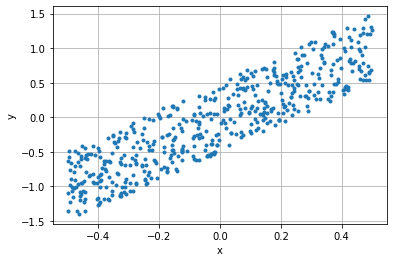

[output:0]

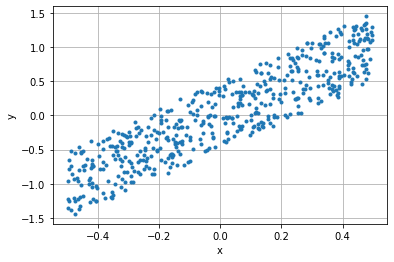

In [12]:
%%px
x_plot = []
y_plot = []
for x, y in train_loader:
    x_plot.append(x.numpy())
    y_plot.append(y.numpy())
    
x_plot = np.array(x_plot).flatten()
y_plot = np.array(y_plot).flatten()

plt.plot(x_plot, y_plot, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Defining the model and choosing an optimizer

In [13]:
%%px
model = torch.nn.Linear(1, 1, bias=True, device=device)

lr = 0.25
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Training

In [16]:
%%px
# synchronize the initial value of the parameters
# in all ranks
with torch.no_grad():
    for p in model.parameters():
        dist.broadcast(p, src=0)

[stderr:1] libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/27.1-7.0.3.1_4.6__g4beae6eb.ari/etc/libibverbs.d'.


[stderr:0] libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/27.1-7.0.3.1_4.6__g4beae6eb.ari/etc/libibverbs.d'.


In [17]:
%%px
num_epochs = 50
history = []

for epoch in range(num_epochs):
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = F.mse_loss(y_hat, y.to(device))
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                # average gradient 
                dist.all_reduce(p.grad, op=dist.ReduceOp.SUM)
                p.grad /= world_size
                #                
                p -= lr * p.grad  # update parameters                
                p.grad = None     # clear the gradient computation

        history.append([model.weight.item(),
                        model.bias.item(),
                        loss.item()])

## Plots

[output:0]

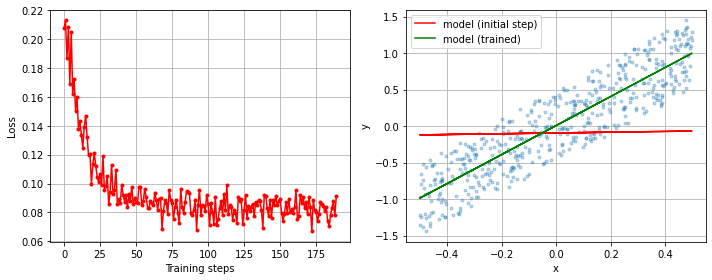

[output:1]

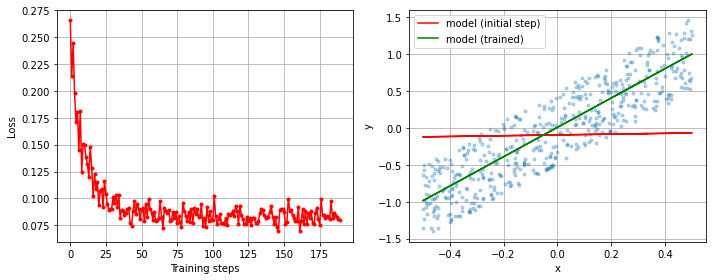

In [18]:
%%px
slope_hist = np.array(history)[:, 0]
offset_hist = np.array(history)[:, 1]
loss_hist = np.array(history)[:, 2]

matplotlib.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_plot, y_plot, '.', alpha=.3)
plt.plot(x_plot, slope_hist[0]  * x_plot + offset_hist[0],  'r-', label='model (initial step)')
plt.plot(x_plot, slope_hist[-1] * x_plot + offset_hist[-1], 'g-', label='model (trained)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

[output:0]

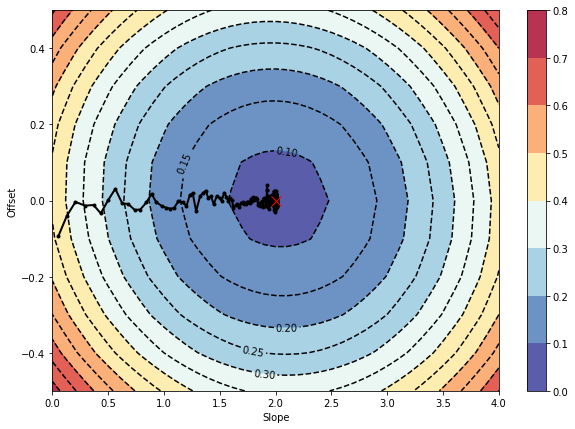

[output:1]

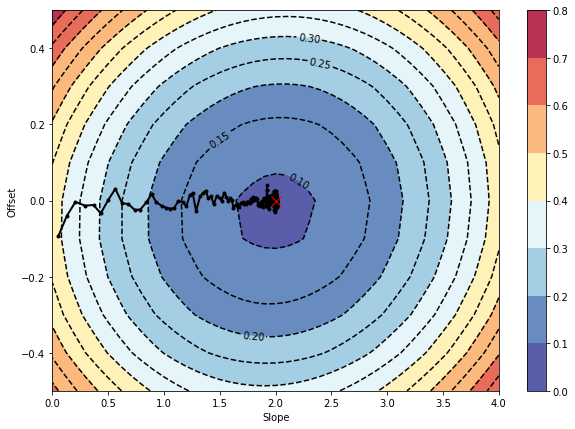

In [19]:
%%px
def loss_function_field(m, n, xref, yref):
    '''Utility function for ploting the loss'''
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_plot, y_plot)

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

cp = plt.contour(M, N, Z, 15, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles='--')
plt.contourf(M, N, Z, vmin=Z.min(), vmax=Z.max(), alpha=0.8, cmap=plt.cm.RdYlBu_r)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.plot([train_set.ref_slope], [train_set.ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

In [20]:
%ipcluster stop

IPCluster stopped.
